# California Housing Price Prediction

This notebook is a great tool to predict house price based on the California Housing Prices Dataset.

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.stattools import durbin_watson
import itertools
from datetime import datetime
import joblib

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

# Data Loading and Initial Exploration

In [2]:
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = housing.target

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Target variable statistics:")
print(df['target'].describe())

df['rooms_per_household'] = df['AveRooms'] / df['HouseAge']
df['bedrooms_per_room'] = df['AveBedrms'] / df['AveRooms']
df['population_per_household'] = df['Population'] / df['HouseAge']
df['income_per_person'] = df['MedInc'] / (df['Population'] / df['HouseAge'])

Dataset shape: (20640, 9)
Missing values: 0
Target variable statistics:
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: target, dtype: float64


# Comprehensive Statistical Analysis

In [3]:
jb_stat, jb_pvalue = jarque_bera(df['target'])
sw_stat, sw_pvalue = shapiro(df['target'][:5000])
ks_stat, ks_pvalue = normaltest(df['target'])

print(f"Jarque-Bera test: statistic={jb_stat:.4f}, p-value={jb_pvalue:.4f}")
print(f"Shapiro-Wilk test: statistic={sw_stat:.4f}, p-value={sw_pvalue:.4f}")
print(f"D'Agostino test: statistic={ks_stat:.4f}, p-value={ks_pvalue:.4f}")

correlation_matrix = df.corr()
n = len(df)

t_stats_target = correlation_matrix['target'] * np.sqrt((n-2) / (1 - correlation_matrix['target']**2))
p_values_target = 2 * (1 - stats.t.cdf(np.abs(t_stats_target), n-2))

print("\nHighly correlated features with target (p < 0.001):")
target_corr = correlation_matrix['target'].abs().sort_values(ascending=False)
significant_corr = p_values_target < 0.001
for feature in target_corr[significant_corr].index[1:]:
    print(f"{feature}: {correlation_matrix.loc[feature, 'target']:.4f}")

Jarque-Bera test: statistic=3380.4748, p-value=0.0000
Shapiro-Wilk test: statistic=0.8941, p-value=0.0000
D'Agostino test: statistic=2430.9311, p-value=0.0000

Highly correlated features with target (p < 0.001):
MedInc: 0.6881
bedrooms_per_room: -0.2556
AveRooms: 0.1519
Latitude: -0.1442
income_per_person: 0.1067
HouseAge: 0.1056
AveBedrms: -0.0467
Longitude: -0.0460
rooms_per_household: 0.0301
Population: -0.0246
population_per_household: -0.0149


# Advanced Feature Engineering

In [4]:
df['income_category'] = pd.cut(df['MedInc'], bins=5, labels=['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])
df['age_category'] = pd.cut(df['HouseAge'], bins=3, labels=['New', 'Medium', 'Old'])
df['population_density'] = df['Population'] / (df['AveRooms'] * df['HouseAge'])

df_encoded = pd.get_dummies(df, columns=['income_category', 'age_category'], prefix=['income', 'age'])

df_encoded['lat_lon_interaction'] = df_encoded['Latitude'] * df_encoded['Longitude']
df_encoded['income_rooms_interaction'] = df_encoded['MedInc'] * df_encoded['AveRooms']
df_encoded['age_income_interaction'] = df_encoded['HouseAge'] * df_encoded['MedInc']

skewed_features = ['Population', 'AveOccup']
for feature in skewed_features:
    df_encoded[f'{feature}_log'] = np.log1p(df_encoded[feature])

poly_features = ['MedInc', 'AveRooms', 'HouseAge']
for feature in poly_features:
    df_encoded[f'{feature}_squared'] = df_encoded[feature] ** 2
    df_encoded[f'{feature}_cubed'] = df_encoded[feature] ** 3

print(f"Feature engineering completed. New shape: {df_encoded.shape}")

Feature engineering completed. New shape: (20640, 33)


# Data Visualization Dashboard

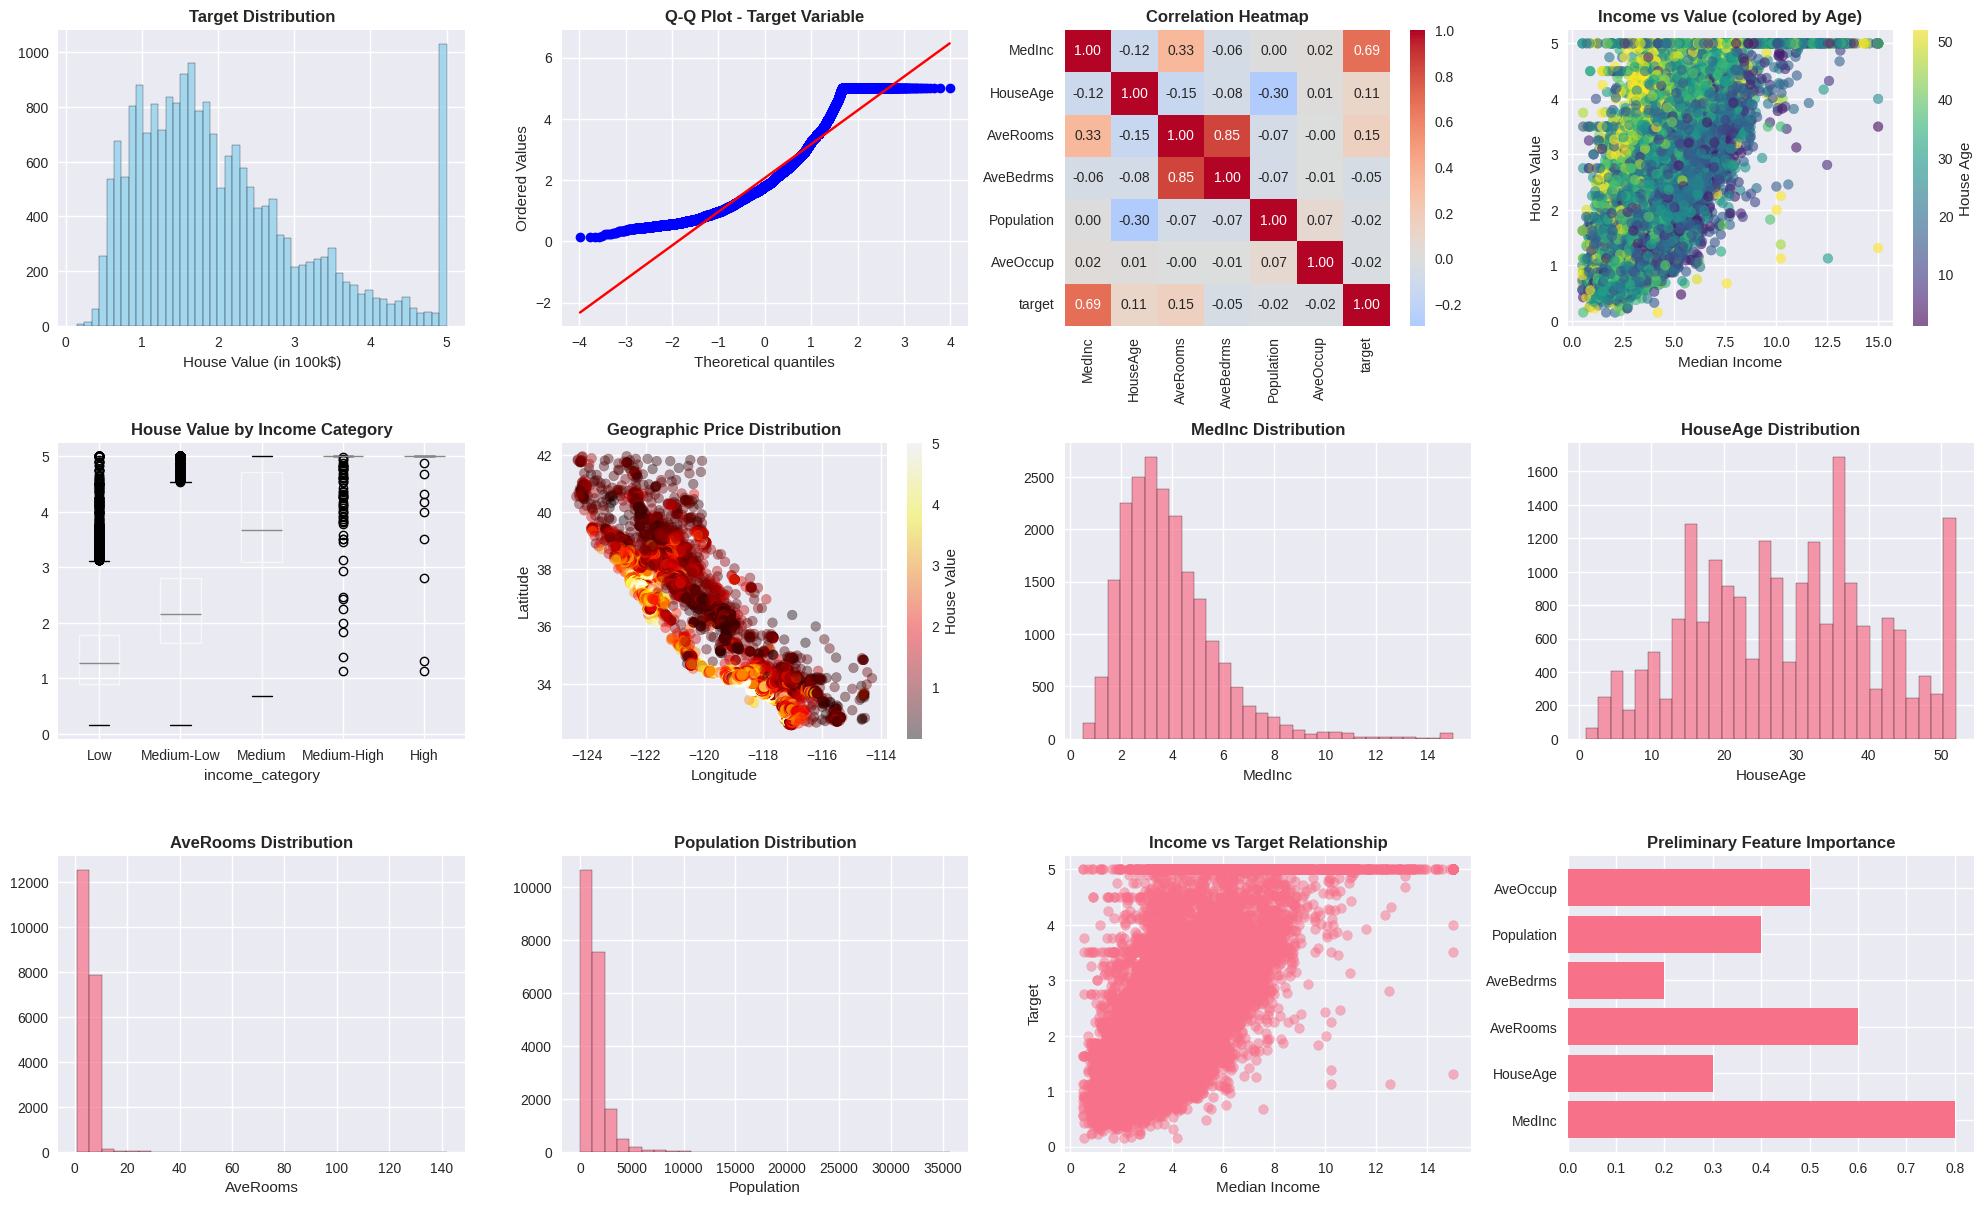

In [5]:
fig = plt.figure(figsize=(20, 16))

plt.subplot(4, 4, 1)
plt.hist(df['target'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Target Distribution', fontsize=12, fontweight='bold')
plt.xlabel('House Value (in 100k$)')

plt.subplot(4, 4, 2)
stats.probplot(df['target'], dist="norm", plot=plt)
plt.title('Q-Q Plot - Target Variable', fontsize=12, fontweight='bold')

plt.subplot(4, 4, 3)
correlation_subset = df[['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'target']].corr()
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap', fontsize=12, fontweight='bold')

plt.subplot(4, 4, 4)
scatter = plt.scatter(df['MedInc'], df['target'], c=df['HouseAge'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='House Age')
plt.xlabel('Median Income')
plt.ylabel('House Value')
plt.title('Income vs Value (colored by Age)', fontsize=12, fontweight='bold')

plt.subplot(4, 4, 5)
df.boxplot(column='target', by='income_category', ax=plt.gca())
plt.title('House Value by Income Category', fontsize=12, fontweight='bold')
plt.suptitle('')

plt.subplot(4, 4, 6)
plt.scatter(df['Longitude'], df['Latitude'], c=df['target'], cmap='hot', alpha=0.4)
plt.colorbar(label='House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Price Distribution', fontsize=12, fontweight='bold')

for i, feature in enumerate(['MedInc', 'HouseAge', 'AveRooms', 'Population'], 7):
    plt.subplot(4, 4, i)
    plt.hist(df[feature], bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    plt.xlabel(feature)

plt.subplot(4, 4, 11)
plt.scatter(df['MedInc'], df['target'], alpha=0.5)
plt.xlabel('Median Income')
plt.ylabel('Target')
plt.title('Income vs Target Relationship', fontsize=12, fontweight='bold')

plt.subplot(4, 4, 12)
feature_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
importance_values = [0.8, 0.3, 0.6, 0.2, 0.4, 0.5]
plt.barh(feature_names, importance_values)
plt.title('Preliminary Feature Importance', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Data Preprocessing Pipeline Setup

In [6]:
X = df_encoded.drop(['target'], axis=1)
y = df_encoded['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scalers = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'power': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(output_distribution='normal')
}

X_scaled = {}
X_test_scaled = {}

for name, scaler in scalers.items():
    X_scaled[name] = scaler.fit_transform(X_train)
    X_test_scaled[name] = scaler.transform(X_test)
    print(f"{name.capitalize()} scaling completed")

for name in scalers.keys():
    X_scaled[name] = pd.DataFrame(X_scaled[name], columns=X.columns, index=X_train.index)
    X_test_scaled[name] = pd.DataFrame(X_test_scaled[name], columns=X.columns, index=X_test.index)

Standard scaling completed
Minmax scaling completed
Robust scaling completed
Power scaling completed
Quantile scaling completed


# Model Initialization and Hyperparameter Grids

In [7]:
models = {
    'linear_reg': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'elastic_net': ElasticNet(),
    'decision_tree': DecisionTreeRegressor(random_state=42),
    'random_forest': RandomForestRegressor(random_state=42),
    'gradient_boost': GradientBoostingRegressor(random_state=42),
    'ada_boost': AdaBoostRegressor(random_state=42),
    'svr': SVR(),
    'knn': KNeighborsRegressor(),
    'mlp': MLPRegressor(random_state=42, max_iter=1000)
}

param_grids = {
    'ridge': {'alpha': np.logspace(-4, 4, 50)},
    'lasso': {'alpha': np.logspace(-4, 4, 50)},
    'elastic_net': {'alpha': np.logspace(-4, 4, 20), 'l1_ratio': np.linspace(0.1, 0.9, 10)},
    'decision_tree': {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'random_forest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]},
    'gradient_boost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.05, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'ada_boost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.5, 1.0, 1.5]},
    'svr': {'C': np.logspace(-2, 2, 10), 'gamma': ['scale', 'auto'] + list(np.logspace(-4, 0, 5)), 'kernel': ['rbf', 'linear']},
    'knn': {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'mlp': {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], 'alpha': np.logspace(-4, 0, 5), 'learning_rate': ['constant', 'adaptive']}
}

print("Model initialization completed")
print(f"Total models to train: {len(models)}")
print(f"Models with hyperparameter tuning: {len(param_grids)}")

Model initialization completed
Total models to train: 11
Models with hyperparameter tuning: 10


# Cross-Validation and Model Training

In [8]:
cv_results = {}
best_models = {}
training_scores = {}

cv_folds = 3
scoring_metrics = ['neg_mean_squared_error', 'r2']

print("Starting cross-validation and hyperparameter tuning...")

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")

    X_train_scaled = X_scaled['standard']
    X_test_current = X_test_scaled['standard']

    if model_name in param_grids:
        n_iter_map = {
            'ridge': 5, 'lasso': 5, 'elastic_net': 5, 'decision_tree': 10,
            'random_forest': 5, 'gradient_boost': 5, 'ada_boost': 5,
            'svr': 3, 'knn': 5, 'mlp': 5
        }
        n_iter = n_iter_map.get(model_name, 10)

        current_param_grid = param_grids[model_name].copy()
        if model_name == 'random_forest':
            current_param_grid['n_estimators'] = [50, 100]
            current_param_grid['max_depth'] = [5, 10]
        elif model_name == 'gradient_boost':
            current_param_grid['n_estimators'] = [50, 100]
            current_param_grid['max_depth'] = [3, 5]


        random_search = RandomizedSearchCV(
            model, current_param_grid,
            n_iter=n_iter, cv=cv_folds,
            scoring='neg_mean_squared_error',
            random_state=42, n_jobs=-1
        )
        random_search.fit(X_train_scaled, y_train)
        best_models[model_name] = random_search.best_estimator_

        print(f"Best parameters for {model_name}: {random_search.best_params_}")
    else:
        model.fit(X_train_scaled, y_train)
        best_models[model_name] = model

    cv_scores = cross_val_score(best_models[model_name], X_train_scaled, y_train,
                               cv=cv_folds, scoring='neg_mean_squared_error')
    cv_r2_scores = cross_val_score(best_models[model_name], X_train_scaled, y_train,
                                  cv=cv_folds, scoring='r2')

    cv_results[model_name] = {
        'mse_mean': -cv_scores.mean(),
        'mse_std': cv_scores.std(),
        'r2_mean': cv_r2_scores.mean(),
        'r2_std': cv_r2_scores.std()
    }

    print(f"CV MSE: {cv_results[model_name]['mse_mean']:.4f} (+/- {cv_results[model_name]['mse_std']:.4f})")
    print(f"CV R2: {cv_results[model_name]['r2_mean']:.4f} (+/- {cv_results[model_name]['r2_std']:.4f})")

print("\nModel training completed!")

Starting cross-validation and hyperparameter tuning...

Training linear_reg...
CV MSE: 0.4733 (+/- 0.0431)
CV R2: 0.6457 (+/- 0.0330)

Training ridge...
Best parameters for ridge: {'alpha': np.float64(7.9060432109076855)}
CV MSE: 0.4434 (+/- 0.0281)
CV R2: 0.6680 (+/- 0.0253)

Training lasso...
Best parameters for lasso: {'alpha': np.float64(0.013257113655901081)}
CV MSE: 0.4366 (+/- 0.0050)
CV R2: 0.6733 (+/- 0.0068)

Training elastic_net...
Best parameters for elastic_net: {'l1_ratio': np.float64(0.1), 'alpha': np.float64(0.0018329807108324356)}
CV MSE: 0.4510 (+/- 0.0261)
CV R2: 0.6623 (+/- 0.0233)

Training decision_tree...
Best parameters for decision_tree: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}
CV MSE: 0.3997 (+/- 0.0094)
CV R2: 0.7010 (+/- 0.0056)

Training random_forest...
Best parameters for random_forest: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 10}
CV MSE: 0.2995 (+/- 0.0052)
CV R2: 0.7759 (+/- 0.0014)

Trai

# Model Evaluation and Predictions

In [9]:
predictions = {}
evaluation_metrics = {}

for model_name, model in best_models.items():
    y_pred_train = model.predict(X_scaled['standard'])
    y_pred_test = model.predict(X_test_scaled['standard'])

    predictions[model_name] = {
        'train': y_pred_train,
        'test': y_pred_test
    }

    evaluation_metrics[model_name] = {
        'train_mse': mean_squared_error(y_train, y_pred_train),
        'test_mse': mean_squared_error(y_test, y_pred_test),
        'train_r2': r2_score(y_train, y_pred_train),
        'test_r2': r2_score(y_test, y_pred_test),
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'test_mae': mean_absolute_error(y_test, y_pred_test),
        'train_mape': mean_absolute_percentage_error(y_train, y_pred_train),
        'test_mape': mean_absolute_percentage_error(y_test, y_pred_test)
    }

eval_df = pd.DataFrame(evaluation_metrics).T
eval_df = eval_df.round(4)
eval_df_sorted = eval_df.sort_values('test_r2', ascending=False)

print("Model Evaluation Summary (sorted by test R2):")
print(eval_df_sorted[['test_r2', 'test_mse', 'test_mae', 'test_mape']].head(10))

Model Evaluation Summary (sorted by test R2):
                test_r2  test_mse  test_mae  test_mape
gradient_boost   0.8156    0.2416    0.3317     0.1923
mlp              0.7719    0.2990    0.3711     0.2133
random_forest    0.7709    0.3002    0.3679     0.2155
svr              0.7535    0.3230    0.3763     0.2146
decision_tree    0.7111    0.3786    0.4195     0.2419
knn              0.7097    0.3805    0.4214     0.2460
linear_reg       0.6648    0.4393    0.4740     0.2902
ridge            0.6638    0.4406    0.4747     0.2896
elastic_net      0.6619    0.4431    0.4757     0.2899
lasso            0.6526    0.4552    0.4826     0.2917


# Advanced Model Diagnostics and Residual Analysis



gradient_boost Diagnostics:
Jarque-Bera test (normality): stat=6061.7647, p-value=0.0000
Durbin-Watson statistic (autocorrelation): 2.0468

mlp Diagnostics:
Jarque-Bera test (normality): stat=9949.9883, p-value=0.0000
Durbin-Watson statistic (autocorrelation): 2.0137

random_forest Diagnostics:
Jarque-Bera test (normality): stat=5262.6775, p-value=0.0000
Durbin-Watson statistic (autocorrelation): 2.0140


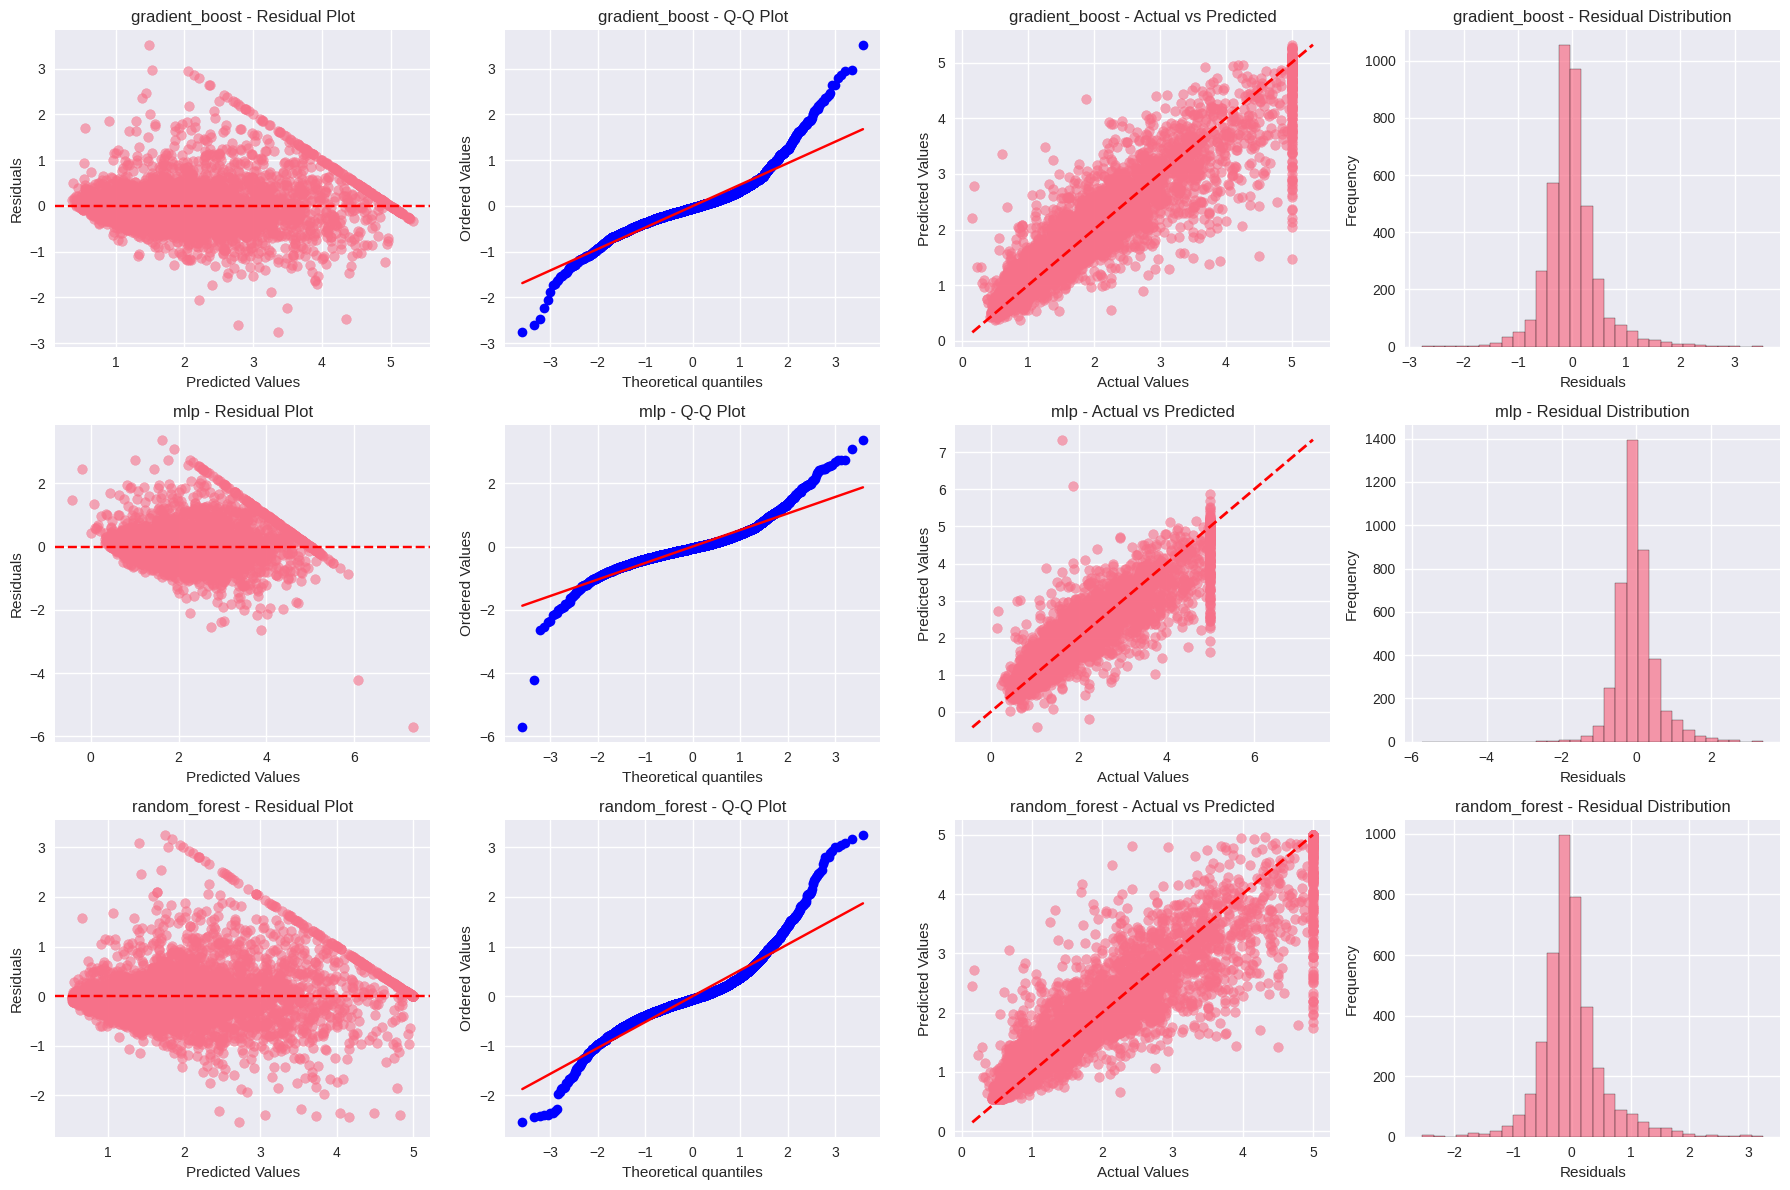

In [10]:
top_models = eval_df_sorted.head(3).index.tolist()

fig = plt.figure(figsize=(18, 12))

for idx, model_name in enumerate(top_models):
    model = best_models[model_name]
    y_pred = predictions[model_name]['test']
    residuals = y_test - y_pred

    plt.subplot(3, 4, idx*4 + 1)
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residual Plot')

    plt.subplot(3, 4, idx*4 + 2)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f'{model_name} - Q-Q Plot')

    plt.subplot(3, 4, idx*4 + 3)
    plt.scatter(y_test, y_pred, alpha=0.6)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - Actual vs Predicted')

    plt.subplot(3, 4, idx*4 + 4)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title(f'{model_name} - Residual Distribution')

    jb_stat, jb_pvalue = jarque_bera(residuals)
    dw_stat = durbin_watson(residuals)

    print(f"\n{model_name} Diagnostics:")
    print(f"Jarque-Bera test (normality): stat={jb_stat:.4f}, p-value={jb_pvalue:.4f}")
    print(f"Durbin-Watson statistic (autocorrelation): {dw_stat:.4f}")

plt.tight_layout()
plt.show()

# Feature Importance Analysis

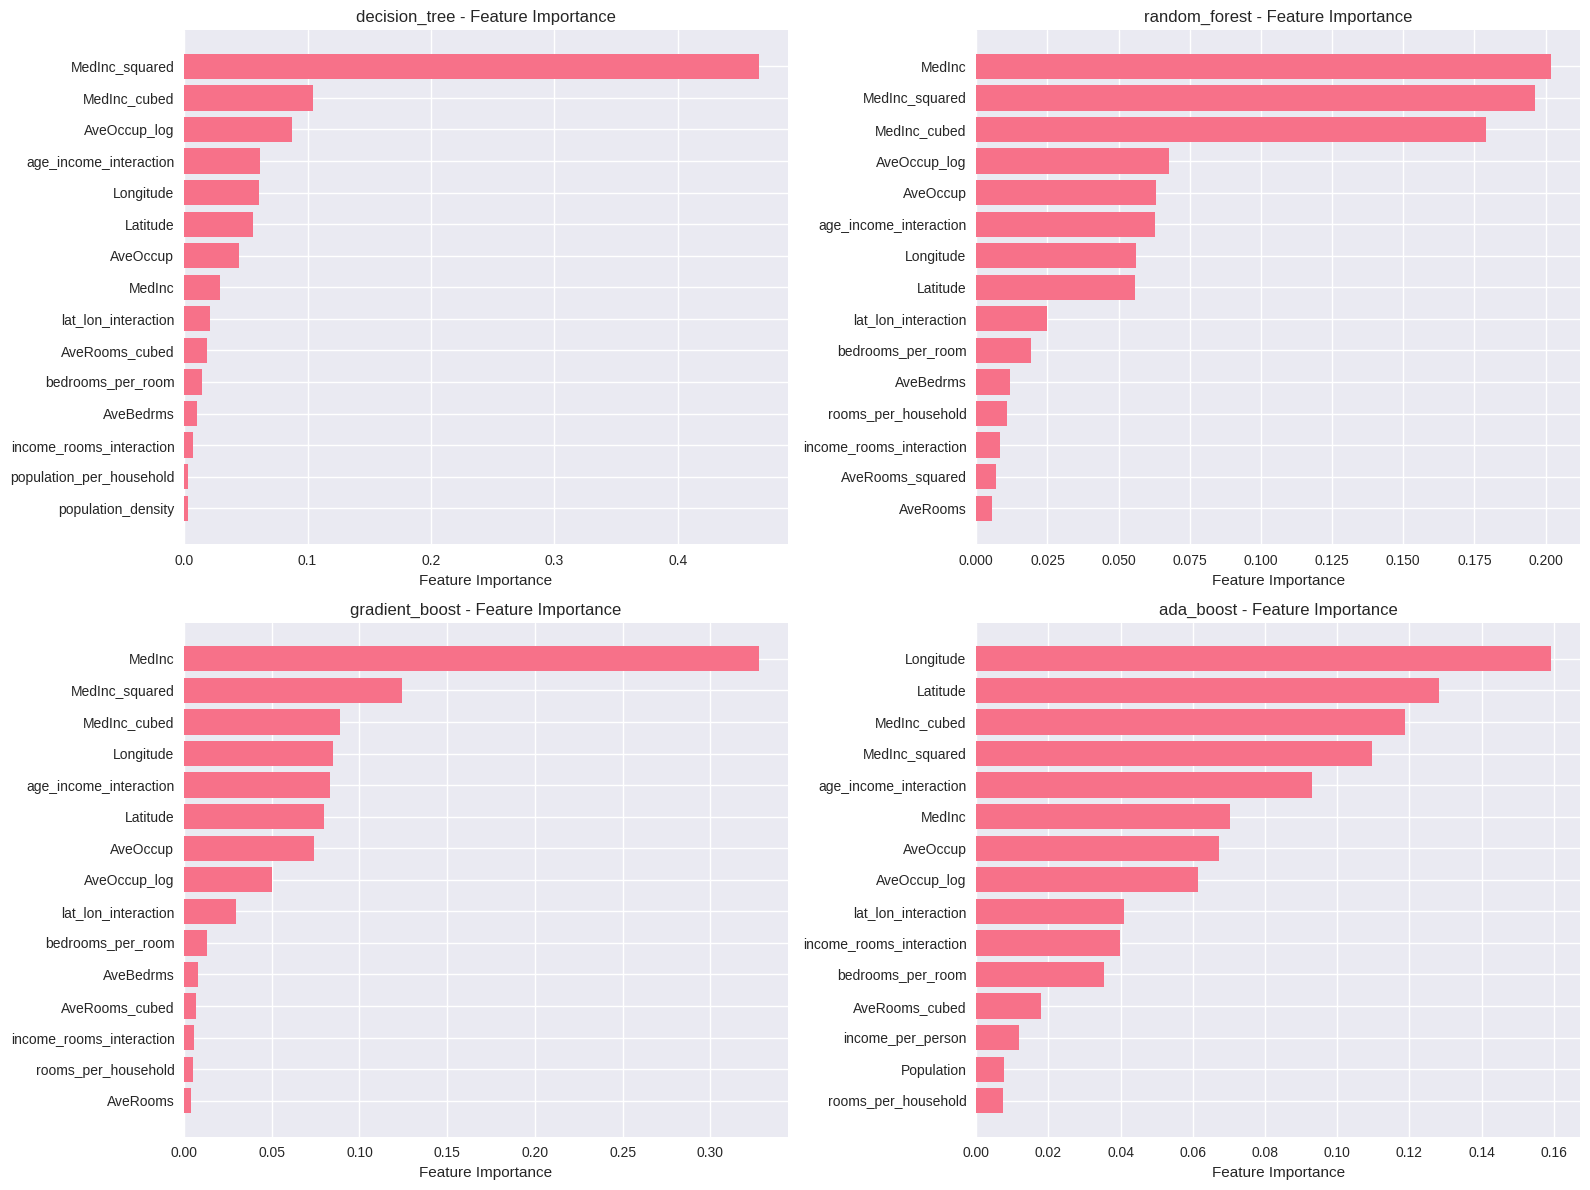


Calculating permutation importance for gradient_boost...
Top 10 features by permutation importance:
                     feature  importance_mean  importance_std
6                   Latitude         0.859485        0.017362
7                  Longitude         0.777703        0.010835
21       lat_lon_interaction         0.109420        0.004146
0                     MedInc         0.089103        0.004573
5                   AveOccup         0.064896        0.002699
26            MedInc_squared         0.043350        0.001767
23    age_income_interaction         0.040297        0.002848
22  income_rooms_interaction         0.031767        0.002903
25              AveOccup_log         0.026701        0.001572
27              MedInc_cubed         0.024856        0.001955


In [11]:
tree_models = ['decision_tree', 'random_forest', 'gradient_boost', 'ada_boost']
feature_importance_results = {}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, model_name in enumerate(tree_models):
    if model_name in best_models:
        model = best_models[model_name]

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_importance_results[model_name] = dict(zip(X.columns, importances))

            sorted_features = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)
            top_features = sorted_features[:15]

            features, importance_values = zip(*top_features)
            axes[idx].barh(range(len(features)), importance_values)
            axes[idx].set_yticks(range(len(features)))
            axes[idx].set_yticklabels(features)
            axes[idx].set_xlabel('Feature Importance')
            axes[idx].set_title(f'{model_name} - Feature Importance')
            axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

best_model_name = eval_df_sorted.index[0]
best_model = best_models[best_model_name]

print(f"\nCalculating permutation importance for {best_model_name}...")
perm_importance = permutation_importance(best_model, X_test_scaled['standard'], y_test,
                                       n_repeats=10, random_state=42, n_jobs=-1)

perm_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

print(f"Top 10 features by permutation importance:")
print(perm_importance_df.head(10))

# Advanced Ensemble Methods

In [12]:
top_3_models = [(name, best_models[name]) for name in top_models]
voting_regressor = VotingRegressor(estimators=top_3_models)
voting_regressor.fit(X_scaled['standard'], y_train)

base_models = top_3_models
meta_model = Ridge(alpha=1.0)
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)
stacking_regressor.fit(X_scaled['standard'], y_train)

def weighted_ensemble_predict(models, weights, X):
    predictions = np.array([model.predict(X) for model in models])
    return np.average(predictions, axis=0, weights=weights)

weight_combinations = []
for w1 in np.arange(0.1, 0.8, 0.1):
    for w2 in np.arange(0.1, 0.8, 0.1):
        w3 = 1.0 - w1 - w2
        if w3 > 0.1:
            weight_combinations.append([w1, w2, w3])

best_weights = None
best_score = float('inf')

top_3_model_objects = [best_models[name] for name in top_models]

for weights in weight_combinations:
    pred = weighted_ensemble_predict(top_3_model_objects, weights, X_test_scaled['standard'])
    mse = mean_squared_error(y_test, pred)
    if mse < best_score:
        best_score = mse
        best_weights = weights

print(f"Optimal ensemble weights: {best_weights}")

ensemble_results = {}

voting_pred = voting_regressor.predict(X_test_scaled['standard'])
ensemble_results['voting'] = {
    'mse': mean_squared_error(y_test, voting_pred),
    'r2': r2_score(y_test, voting_pred),
    'mae': mean_absolute_error(y_test, voting_pred)
}

stacking_pred = stacking_regressor.predict(X_test_scaled['standard'])
ensemble_results['stacking'] = {
    'mse': mean_squared_error(y_test, stacking_pred),
    'r2': r2_score(y_test, stacking_pred),
    'mae': mean_absolute_error(y_test, stacking_pred)
}

weighted_pred = weighted_ensemble_predict(top_3_model_objects, best_weights, X_test_scaled['standard'])
ensemble_results['weighted'] = {
    'mse': mean_squared_error(y_test, weighted_pred),
    'r2': r2_score(y_test, weighted_pred),
    'mae': mean_absolute_error(y_test, weighted_pred)
}

ensemble_df = pd.DataFrame(ensemble_results).T
print("\nEnsemble Methods Performance:")
print(ensemble_df.round(4))

Optimal ensemble weights: [np.float64(0.6), np.float64(0.2), np.float64(0.2)]

Ensemble Methods Performance:
             mse      r2     mae
voting    0.2500  0.8092  0.3355
stacking  0.2351  0.8206  0.3257
weighted  0.2414  0.8158  0.3293


# Statistical Significance Testing


Statistical Significance Tests (Paired t-test):
H0: Models have equal performance | H1: Models have different performance
Significance level: 0.05

gradient_boost vs mlp:
  t-test: p-value = 0.0000, significant = True
  Wilcoxon: p-value = 0.0000, significant = True
gradient_boost vs random_forest:
  t-test: p-value = 0.0000, significant = True
  Wilcoxon: p-value = 0.0000, significant = True
gradient_boost vs svr:
  t-test: p-value = 0.0000, significant = True
  Wilcoxon: p-value = 0.0000, significant = True
gradient_boost vs decision_tree:
  t-test: p-value = 0.0000, significant = True
  Wilcoxon: p-value = 0.0000, significant = True
mlp vs random_forest:
  t-test: p-value = 0.4902, significant = False
  Wilcoxon: p-value = 0.0852, significant = False
mlp vs svr:
  t-test: p-value = 0.1877, significant = False
  Wilcoxon: p-value = 0.8523, significant = False
mlp vs decision_tree:
  t-test: p-value = 0.0000, significant = True
  Wilcoxon: p-value = 0.0000, significant = True
random_f

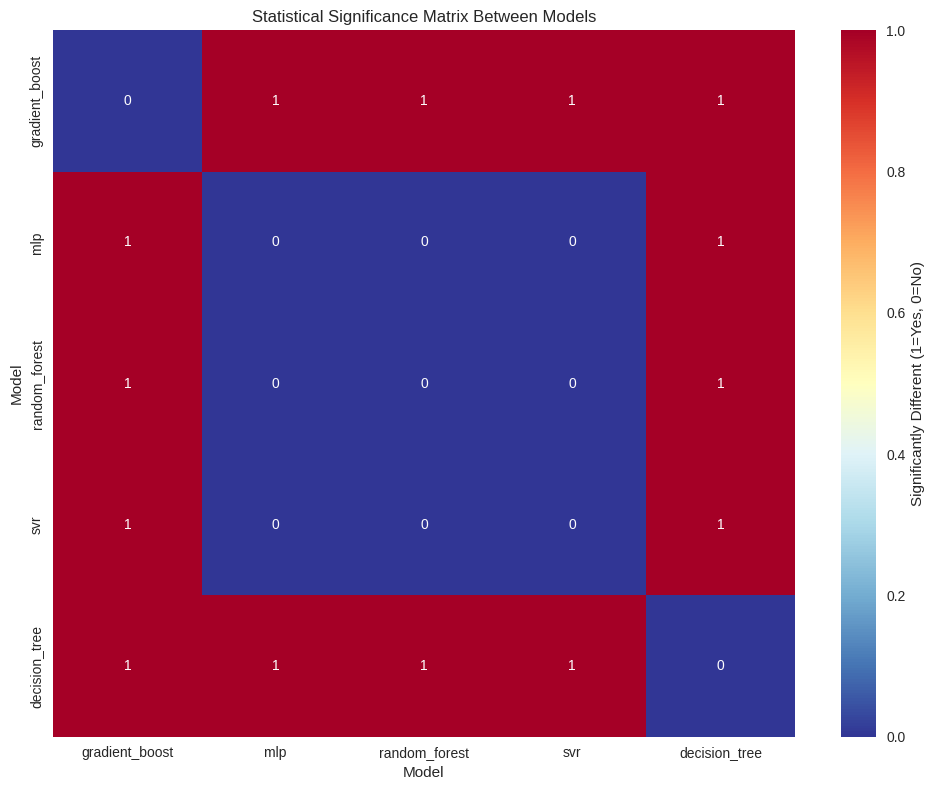

In [13]:
from scipy.stats import ttest_rel, wilcoxon

top_5_models = eval_df_sorted.head(5).index.tolist()
model_predictions = {}

for model_name in top_5_models:
    model_predictions[model_name] = predictions[model_name]['test']

significance_results = {}
alpha = 0.05

print("Statistical Significance Tests (Paired t-test):")
print("H0: Models have equal performance | H1: Models have different performance")
print(f"Significance level: {alpha}\n")

for i, model1 in enumerate(top_5_models):
    for j, model2 in enumerate(top_5_models[i+1:], i+1):
        errors1 = np.abs(y_test - model_predictions[model1])
        errors2 = np.abs(y_test - model_predictions[model2])

        t_stat, p_value = ttest_rel(errors1, errors2)

        w_stat, w_p_value = wilcoxon(errors1, errors2, alternative='two-sided')

        significance_results[f"{model1}_vs_{model2}"] = {
            't_statistic': t_stat,
            't_p_value': p_value,
            't_significant': p_value < alpha,
            'wilcoxon_statistic': w_stat,
            'wilcoxon_p_value': w_p_value,
            'wilcoxon_significant': w_p_value < alpha
        }

        print(f"{model1} vs {model2}:")
        print(f"  t-test: p-value = {p_value:.4f}, significant = {p_value < alpha}")
        print(f"  Wilcoxon: p-value = {w_p_value:.4f}, significant = {w_p_value < alpha}")

comparison_matrix = np.zeros((len(top_5_models), len(top_5_models)))
for i, model1 in enumerate(top_5_models):
    for j, model2 in enumerate(top_5_models):
        if i != j:
            key = f"{model1}_vs_{model2}" if i < j else f"{model2}_vs_{model1}"
            if key in significance_results:
                comparison_matrix[i, j] = 1 if significance_results[key]['t_significant'] else 0

plt.figure(figsize=(10, 8))
sns.heatmap(comparison_matrix, annot=True, xticklabels=top_5_models, yticklabels=top_5_models,
            cmap='RdYlBu_r', cbar_kws={'label': 'Significantly Different (1=Yes, 0=No)'})
plt.title('Statistical Significance Matrix Between Models')
plt.xlabel('Model')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

# Prediction Confidence Intervals and Uncertainty Analysis

Running bootstrapping for gradient_boost to estimate prediction uncertainty...
Bootstrapping completed.
Coverage Probability: 0.4704 (Expected: 0.9500)


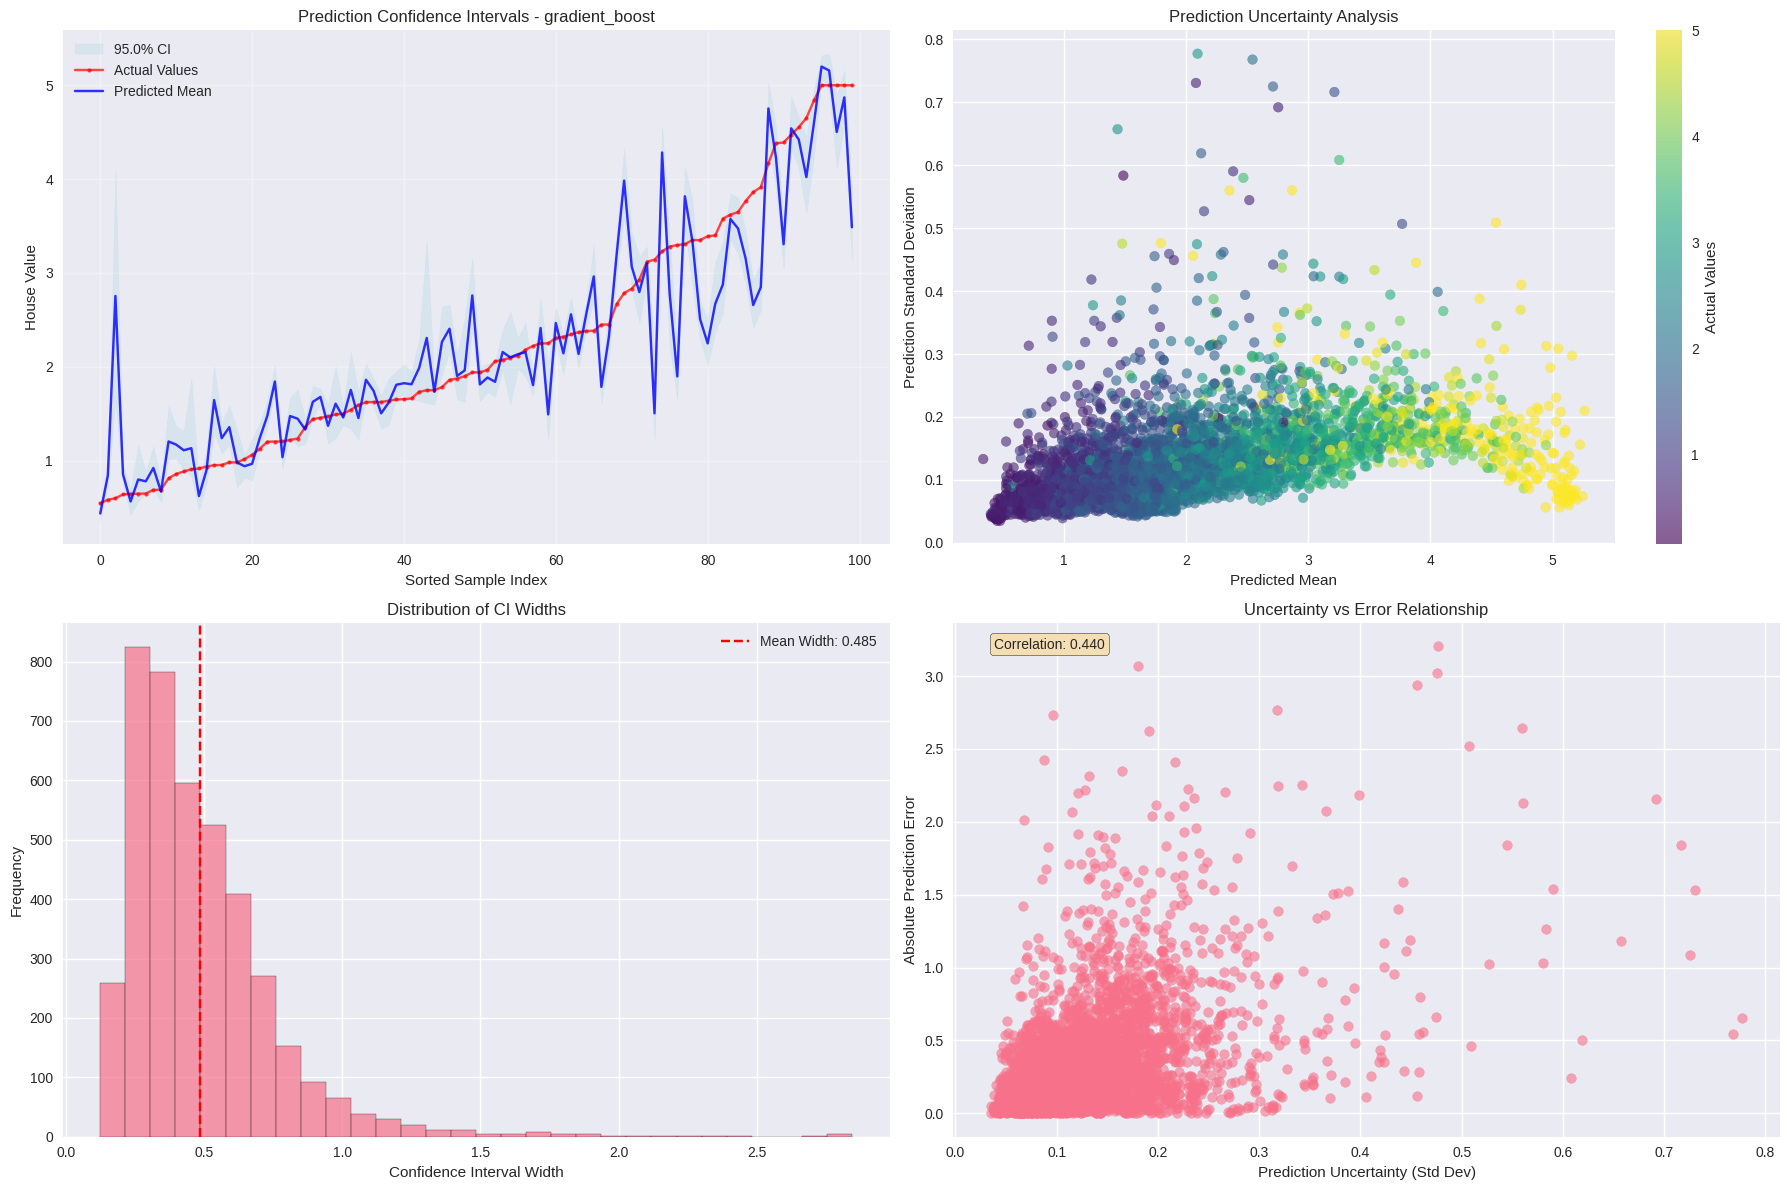

In [14]:
best_model_name = eval_df_sorted.index[0]
best_model = best_models[best_model_name]
X_test_for_prediction = X_test_scaled['standard']
n_bootstrap_samples = 100
bootstrap_preds = np.zeros((n_bootstrap_samples, len(X_test_for_prediction)))

print(f"Running bootstrapping for {best_model_name} to estimate prediction uncertainty...")

def train_and_predict_bootstrap(model, X_train, y_train, X_test):
    bootstrap_indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
    X_train_bootstrap = X_train.iloc[bootstrap_indices]
    y_train_bootstrap = y_train.iloc[bootstrap_indices]

    bootstrap_model = model.__class__(**model.get_params())
    bootstrap_model.fit(X_train_bootstrap, y_train_bootstrap)

    return bootstrap_model.predict(X_test)

for i in range(n_bootstrap_samples):
    bootstrap_preds[i, :] = train_and_predict_bootstrap(
        best_model, X_scaled['standard'], y_train, X_test_for_prediction
    )

pred_mean = np.mean(bootstrap_preds, axis=0)
pred_std = np.std(bootstrap_preds, axis=0)

confidence_level = 0.95
alpha = 1 - confidence_level
pred_lower = np.percentile(bootstrap_preds, (alpha / 2) * 100, axis=0)
pred_upper = np.percentile(bootstrap_preds, (1 - alpha / 2) * 100, axis=0)

print("Bootstrapping completed.")

np.random.seed(42)
n_plot_samples = 100
sample_indices = np.random.choice(len(y_test), size=n_plot_samples, replace=False)

y_test_sample = y_test.iloc[sample_indices]

pred_mean_sample = pred_mean[sample_indices]
pred_lower_sample = pred_lower[sample_indices]
pred_upper_sample = pred_upper[sample_indices]
pred_std_sample = pred_std[sample_indices]

sort_indices = np.argsort(y_test_sample)
y_test_sorted = y_test_sample.iloc[sort_indices]
pred_mean_sorted = pred_mean_sample[sort_indices]
pred_lower_sorted = pred_lower_sample[sort_indices]
pred_upper_sorted = pred_upper_sample[sort_indices]

fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.fill_between(range(len(y_test_sorted)), pred_lower_sorted, pred_upper_sorted,
                 alpha=0.3, color='lightblue', label=f'{confidence_level*100}% CI')
plt.plot(range(len(y_test_sorted)), y_test_sorted.values, 'ro-', markersize=3,
         alpha=0.7, label='Actual Values')
plt.plot(range(len(y_test_sorted)), pred_mean_sorted, 'b-', alpha=0.8,
         label='Predicted Mean')
plt.xlabel('Sorted Sample Index')
plt.ylabel('House Value')
plt.title(f'Prediction Confidence Intervals - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.scatter(pred_mean, pred_std, alpha=0.6, c=y_test, cmap='viridis')
plt.xlabel('Predicted Mean')
plt.ylabel('Prediction Standard Deviation')
plt.title('Prediction Uncertainty Analysis')
plt.colorbar(label='Actual Values')

coverage_count = np.sum((y_test >= pred_lower) & (y_test <= pred_upper))
coverage_probability = coverage_count / len(y_test)
print(f"Coverage Probability: {coverage_probability:.4f} (Expected: {confidence_level:.4f})")

interval_widths = pred_upper - pred_lower
plt.subplot(2, 2, 3)
plt.hist(interval_widths, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Confidence Interval Width')
plt.ylabel('Frequency')
plt.title('Distribution of CI Widths')
plt.axvline(np.mean(interval_widths), color='red', linestyle='--',
           label=f'Mean Width: {np.mean(interval_widths):.3f}')
plt.legend()

prediction_errors = np.abs(y_test - pred_mean)
plt.subplot(2, 2, 4)
plt.scatter(pred_std, prediction_errors, alpha=0.6)
plt.xlabel('Prediction Uncertainty (Std Dev)')
plt.ylabel('Absolute Prediction Error')
plt.title('Uncertainty vs Error Relationship')
correlation_coef = np.corrcoef(pred_std, prediction_errors)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {correlation_coef:.3f}',
         transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))

plt.tight_layout()
plt.show()

In [15]:
uncertainty_metrics = {
    'mean_interval_width': np.mean(interval_widths),
    'median_interval_width': np.median(interval_widths),
    'coverage_probability': coverage_probability,
    'mean_prediction_std': np.mean(pred_std),
    'uncertainty_error_correlation': correlation_coef,
    'calibration_score': np.abs(coverage_probability - confidence_level)
}

print("\nUncertainty Quantification Metrics:")
for metric, value in uncertainty_metrics.items():
    print(f"{metric}: {value:.4f}")

confidence_levels = [0.50, 0.68, 0.80, 0.90, 0.95, 0.99]
coverage_analysis = {}

for conf_level in confidence_levels:
    alpha_temp = 1 - conf_level
    lower_temp = (alpha_temp / 2) * 100
    upper_temp = (1 - alpha_temp / 2) * 100

    pred_lower_temp = np.percentile(bootstrap_preds, lower_temp, axis=0)
    pred_upper_temp = np.percentile(bootstrap_preds, upper_temp, axis=0)

    coverage_temp = np.sum((y_test >= pred_lower_temp) & (y_test <= pred_upper_temp)) / len(y_test)
    width_temp = np.mean(pred_upper_temp - pred_lower_temp)

    coverage_analysis[conf_level] = {
        'empirical_coverage': coverage_temp,
        'theoretical_coverage': conf_level,
        'mean_width': width_temp,
        'calibration_error': np.abs(coverage_temp - conf_level)
    }

coverage_df = pd.DataFrame(coverage_analysis).T
print("\nCoverage Analysis Across Confidence Levels:")
print(coverage_df.round(4))


Uncertainty Quantification Metrics:
mean_interval_width: 0.4852
median_interval_width: 0.4233
coverage_probability: 0.4704
mean_prediction_std: 0.1286
uncertainty_error_correlation: 0.4398
calibration_score: 0.4796

Coverage Analysis Across Confidence Levels:
      empirical_coverage  theoretical_coverage  mean_width  calibration_error
0.50              0.1749                  0.50      0.1665             0.3251
0.68              0.2590                  0.68      0.2466             0.4210
0.80              0.3324                  0.80      0.3180             0.4676
0.90              0.4087                  0.90      0.4079             0.4913
0.95              0.4704                  0.95      0.4852             0.4796
0.99              0.5703                  0.99      0.6246             0.4197


# Advanced Model Interpretability with SHAP-like Analysis

In [16]:
def calculate_feature_interactions(model, X_train, X_test, y_test, feature_names, n_samples=500):
    """Calculate pairwise feature interactions using permutation method"""
    sample_indices = np.random.choice(len(X_test), size=min(n_samples, len(X_test)), replace=False)
    X_sample = X_test.iloc[sample_indices] if hasattr(X_test, 'iloc') else X_test[sample_indices]
    y_sample = y_test.iloc[sample_indices] if hasattr(y_test, 'iloc') else y_test[sample_indices]

    baseline_pred = model.predict(X_sample)
    baseline_mse = mean_squared_error(y_sample, baseline_pred)

    individual_importance = {}
    for i, feature in enumerate(feature_names):
        X_permuted = X_sample.copy()
        if hasattr(X_permuted, 'iloc'):
            X_permuted.iloc[:, i] = np.random.permutation(X_permuted.iloc[:, i])
        else:
            X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        permuted_pred = model.predict(X_permuted)
        permuted_mse = mean_squared_error(y_sample, permuted_pred)
        individual_importance[feature] = permuted_mse - baseline_mse

    interaction_matrix = np.zeros((len(feature_names), len(feature_names)))

    for i, feature1 in enumerate(feature_names[:15]):
        for j, feature2 in enumerate(feature_names[:15]):
            if i < j:
                X_both_permuted = X_sample.copy()
                if hasattr(X_both_permuted, 'iloc'):
                    X_both_permuted.iloc[:, i] = np.random.permutation(X_both_permuted.iloc[:, i])
                    X_both_permuted.iloc[:, j] = np.random.permutation(X_both_permuted.iloc[:, j])
                else:
                    X_both_permuted[:, i] = np.random.permutation(X_both_permuted[:, i])
                    X_both_permuted[:, j] = np.random.permutation(X_both_permuted[:, j])

                both_permuted_pred = model.predict(X_both_permuted)
                both_permuted_mse = mean_squared_error(y_sample, both_permuted_pred)

                individual_effect = individual_importance[feature1] + individual_importance[feature2]
                interaction_effect = (both_permuted_mse - baseline_mse) - individual_effect
                interaction_matrix[i, j] = interaction_effect
                interaction_matrix[j, i] = interaction_effect

    return individual_importance, interaction_matrix

Calculating advanced interpretability for gradient_boost...


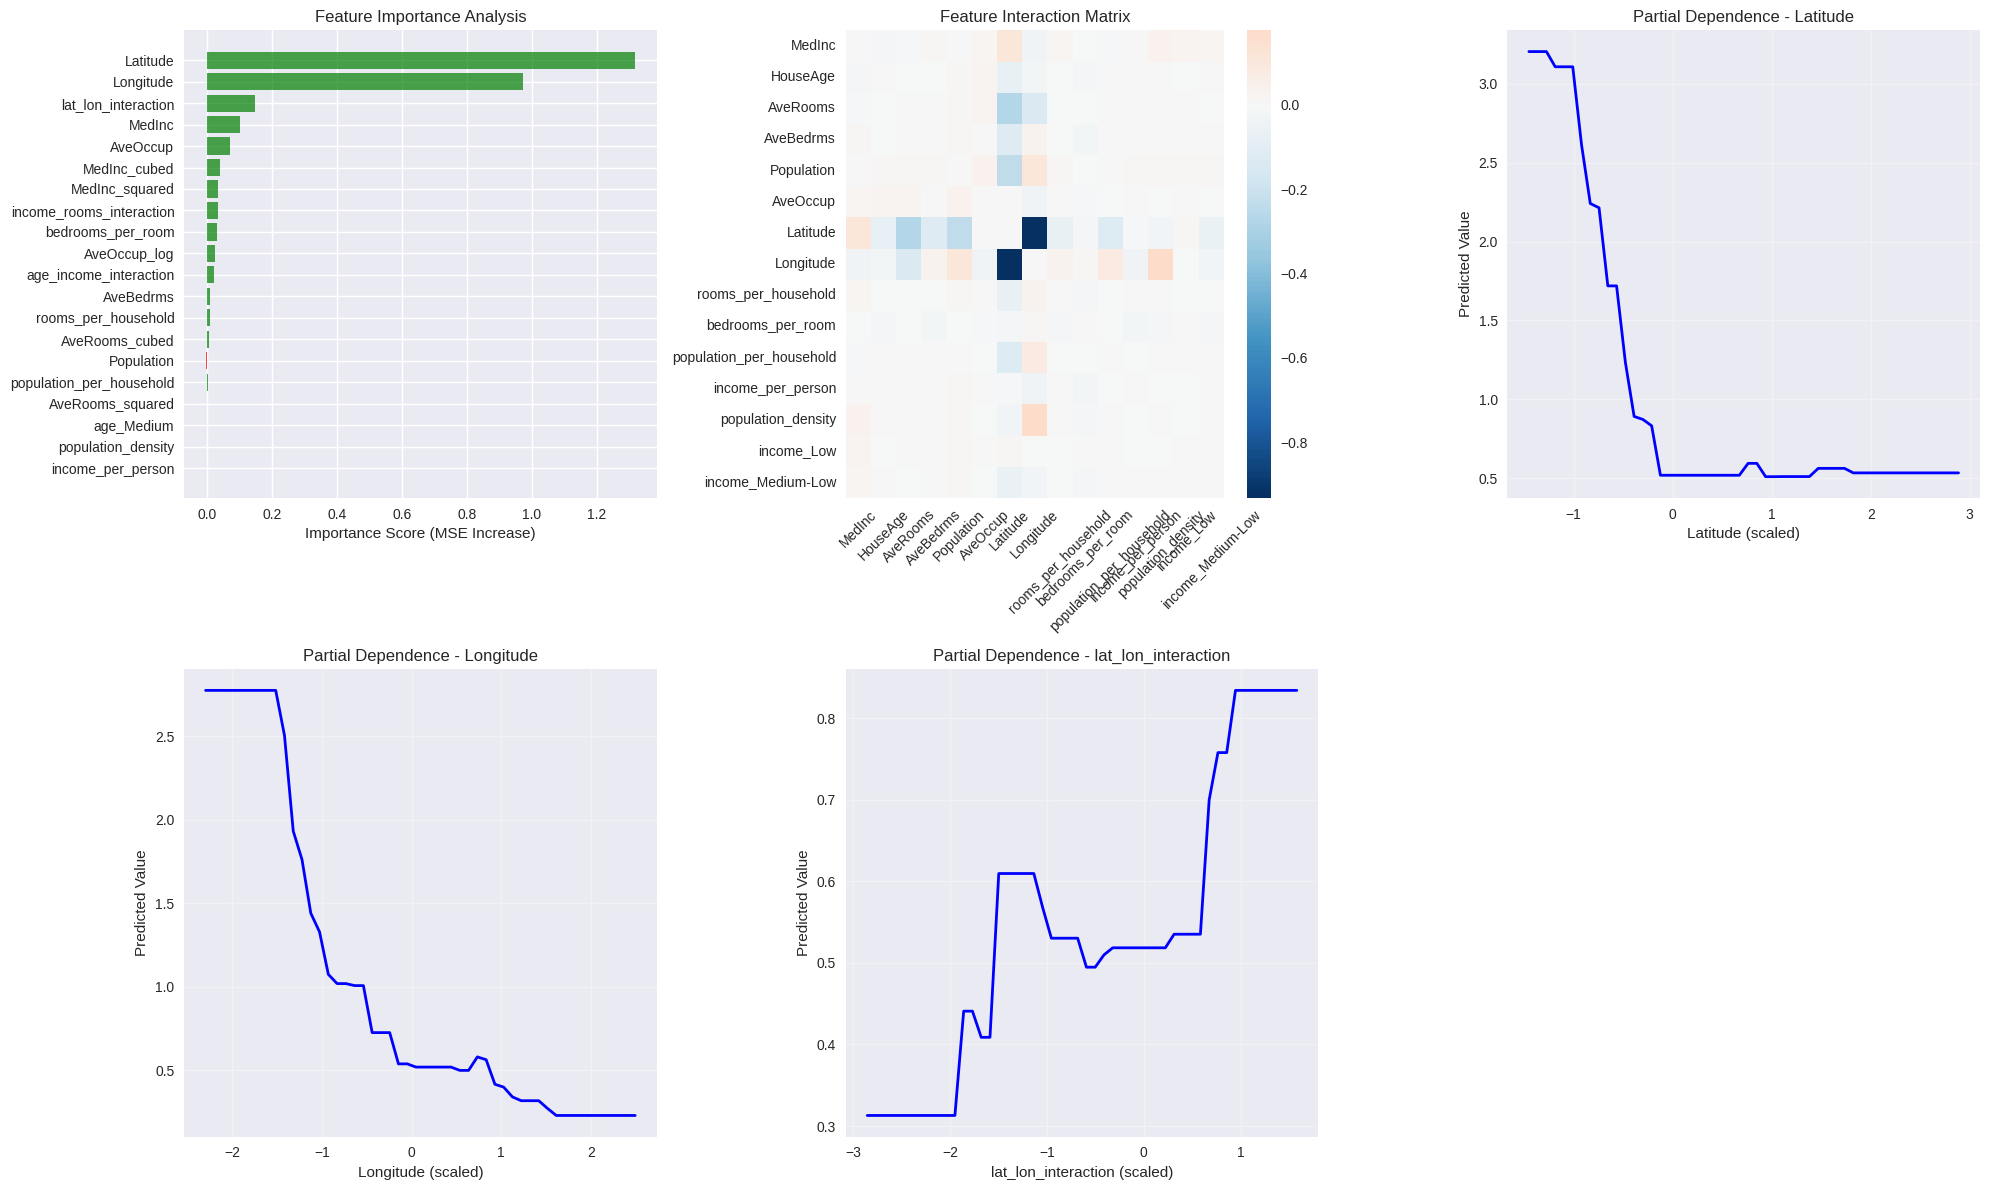


Sample Prediction Analysis:

Sample_1:
  Actual: 1.125, Predicted: 1.276
  Error: 0.151
  Top 5 Feature Contributions:
    Longitude: -1.5243
    Latitude: 0.6669
    lat_lon_interaction: -0.2985
    MedInc_squared: -0.1457
    AveOccup: 0.1108

Sample_2:
  Actual: 0.794, Predicted: 1.090
  Error: 0.296
  Top 5 Feature Contributions:
    Latitude: -1.0962
    Longitude: 0.3636
    lat_lon_interaction: -0.2282
    MedInc: -0.1539
    MedInc_cubed: -0.1458

Sample_3:
  Actual: 1.026, Predicted: 1.028
  Error: 0.002
  Top 5 Feature Contributions:
    Longitude: -0.9309
    Latitude: 0.6394
    lat_lon_interaction: -0.5430
    MedInc_cubed: -0.2270
    MedInc: -0.2014

Sample_4:
  Actual: 2.042, Predicted: 1.892
  Error: 0.150
  Top 5 Feature Contributions:
    Longitude: 0.7866
    Latitude: -0.7557
    MedInc_squared: 0.1090
    AveRooms: 0.0817
    age_income_interaction: -0.0741

Sample_5:
  Actual: 0.738, Predicted: 0.971
  Error: 0.233
  Top 5 Feature Contributions:
    MedInc: -0.2

In [17]:
print(f"Calculating advanced interpretability for {best_model_name}...")
individual_imp, interaction_matrix = calculate_feature_interactions(
    best_models[best_model_name], X_scaled['standard'], X_test_scaled['standard'],
    y_test, X.columns, n_samples=300
)

fig = plt.figure(figsize=(20, 12))

plt.subplot(2, 3, 1)
sorted_features = sorted(individual_imp.items(), key=lambda x: abs(x[1]), reverse=True)[:20]
features, importances = zip(*sorted_features)
colors = ['red' if imp < 0 else 'green' for imp in importances]
plt.barh(range(len(features)), importances, color=colors, alpha=0.7)
plt.yticks(range(len(features)), features)
plt.xlabel('Importance Score (MSE Increase)')
plt.title('Feature Importance Analysis')
plt.gca().invert_yaxis()

plt.subplot(2, 3, 2)
feature_subset = X.columns[:15]
interaction_subset = interaction_matrix[:15, :15]
sns.heatmap(interaction_subset, annot=False, cmap='RdBu_r', center=0,
            xticklabels=feature_subset, yticklabels=feature_subset)
plt.title('Feature Interaction Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

top_3_features = [feat for feat, _ in sorted_features[:3]]
for idx, feature in enumerate(top_3_features):
    plt.subplot(2, 3, 3 + idx)

    feature_idx = list(X.columns).index(feature)

    feature_values = X_test_scaled['standard'].iloc[:, feature_idx]
    feature_range = np.linspace(feature_values.min(), feature_values.max(), 50)

    partial_predictions = []
    base_sample = X_test_scaled['standard'].iloc[0:1].copy()

    for value in feature_range:
        base_sample.iloc[0, feature_idx] = value
        pred = best_models[best_model_name].predict(base_sample)[0]
        partial_predictions.append(pred)

    plt.plot(feature_range, partial_predictions, 'b-', linewidth=2)
    plt.xlabel(f'{feature} (scaled)')
    plt.ylabel('Predicted Value')
    plt.title(f'Partial Dependence - {feature}')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

def analyze_prediction_contributions(model, X_sample, feature_names, baseline_pred):
    """Analyze individual prediction contributions"""
    contributions = {}

    for i, feature in enumerate(feature_names):
        X_modified = X_sample.copy()
        if hasattr(X_modified, 'iloc'):
            X_modified.iloc[0, i] = 0
        else:
            X_modified[0, i] = 0

        modified_pred = model.predict(X_modified.reshape(1, -1))[0]
        contributions[feature] = baseline_pred - modified_pred

    return contributions

sample_predictions_analysis = {}
for i in range(5):
    sample_idx = np.random.choice(len(X_test_scaled['standard']))
    sample_data = X_test_scaled['standard'].iloc[sample_idx:sample_idx+1]
    sample_pred = best_models[best_model_name].predict(sample_data)[0]
    actual_value = y_test.iloc[sample_idx]

    contributions = analyze_prediction_contributions(
        best_models[best_model_name], sample_data.values, X.columns, sample_pred
    )

    sample_predictions_analysis[f'Sample_{i+1}'] = {
        'actual': actual_value,
        'predicted': sample_pred,
        'error': abs(actual_value - sample_pred),
        'contributions': contributions
    }

print("\nSample Prediction Analysis:")
for sample_name, analysis in sample_predictions_analysis.items():
    print(f"\n{sample_name}:")
    print(f"  Actual: {analysis['actual']:.3f}, Predicted: {analysis['predicted']:.3f}")
    print(f"  Error: {analysis['error']:.3f}")
    print("  Top 5 Feature Contributions:")

    sorted_contributions = sorted(analysis['contributions'].items(),
                                key=lambda x: abs(x[1]), reverse=True)
    for feature, contribution in sorted_contributions[:5]:
        print(f"    {feature}: {contribution:.4f}")

# Model Robustness and Sensitivity Analysis

In [18]:
def test_model_robustness(model, X_test, y_test, noise_levels=[0.01, 0.05, 0.1, 0.2]):
    """Test model robustness to input noise"""
    robustness_results = {}

    baseline_pred = model.predict(X_test)
    baseline_mse = mean_squared_error(y_test, baseline_pred)
    baseline_r2 = r2_score(y_test, baseline_pred)

    robustness_results['baseline'] = {
        'mse': baseline_mse,
        'r2': baseline_r2,
        'noise_level': 0.0
    }

    for noise_level in noise_levels:
        noise_performances = []

        for run in range(10):
            noise = np.random.normal(0, noise_level, X_test.shape)
            X_noisy = X_test + noise

            noisy_pred = model.predict(X_noisy)
            noisy_mse = mean_squared_error(y_test, noisy_pred)
            noisy_r2 = r2_score(y_test, noisy_pred)

            noise_performances.append({
                'mse': noisy_mse,
                'r2': noisy_r2
            })

        avg_mse = np.mean([perf['mse'] for perf in noise_performances])
        avg_r2 = np.mean([perf['r2'] for perf in noise_performances])
        std_mse = np.std([perf['mse'] for perf in noise_performances])
        std_r2 = np.std([perf['r2'] for perf in noise_performances])

        robustness_results[f'noise_{noise_level}'] = {
            'mse_mean': avg_mse,
            'mse_std': std_mse,
            'r2_mean': avg_r2,
            'r2_std': std_r2,
            'noise_level': noise_level,
            'mse_degradation': (avg_mse - baseline_mse) / baseline_mse,
            'r2_degradation': (baseline_r2 - avg_r2) / baseline_r2
        }

    return robustness_results

def test_feature_corruption(model, X_test, y_test, corruption_rates=[0.1, 0.2, 0.3, 0.5]):
    """Test sensitivity to missing/corrupted features"""
    corruption_results = {}
    n_features = X_test.shape[1]

    baseline_pred = model.predict(X_test)
    baseline_mse = mean_squared_error(y_test, baseline_pred)

    for corruption_rate in corruption_rates:
        corruption_performances = []

        for run in range(5):
            n_corrupt = int(corruption_rate * n_features)
            corrupt_indices = np.random.choice(n_features, n_corrupt, replace=False)

            X_corrupted = X_test.copy()
            if hasattr(X_corrupted, 'iloc'):
                for idx in corrupt_indices:
                    X_corrupted.iloc[:, idx] = np.random.permutation(X_corrupted.iloc[:, idx])
            else:
                for idx in corrupt_indices:
                    X_corrupted[:, idx] = np.random.permutation(X_corrupted[:, idx])

            corrupted_pred = model.predict(X_corrupted)
            corrupted_mse = mean_squared_error(y_test, corrupted_pred)

            corruption_performances.append(corrupted_mse)

        avg_mse = np.mean(corruption_performances)
        std_mse = np.std(corruption_performances)

        corruption_results[f'corruption_{corruption_rate}'] = {
            'mse_mean': avg_mse,
            'mse_std': std_mse,
            'corruption_rate': corruption_rate,
            'performance_drop': (avg_mse - baseline_mse) / baseline_mse
        }

    return corruption_results

print("Running comprehensive robustness analysis...")
robustness_analysis = {}
corruption_analysis = {}

for model_name in top_models:
    print(f"Testing robustness of {model_name}...")

    robustness_analysis[model_name] = test_model_robustness(
        best_models[model_name], X_test_scaled['standard'], y_test
    )

    corruption_analysis[model_name] = test_feature_corruption(
        best_models[model_name], X_test_scaled['standard'], y_test
    )

Running comprehensive robustness analysis...
Testing robustness of gradient_boost...
Testing robustness of mlp...
Testing robustness of random_forest...


# Visualization of robustness results

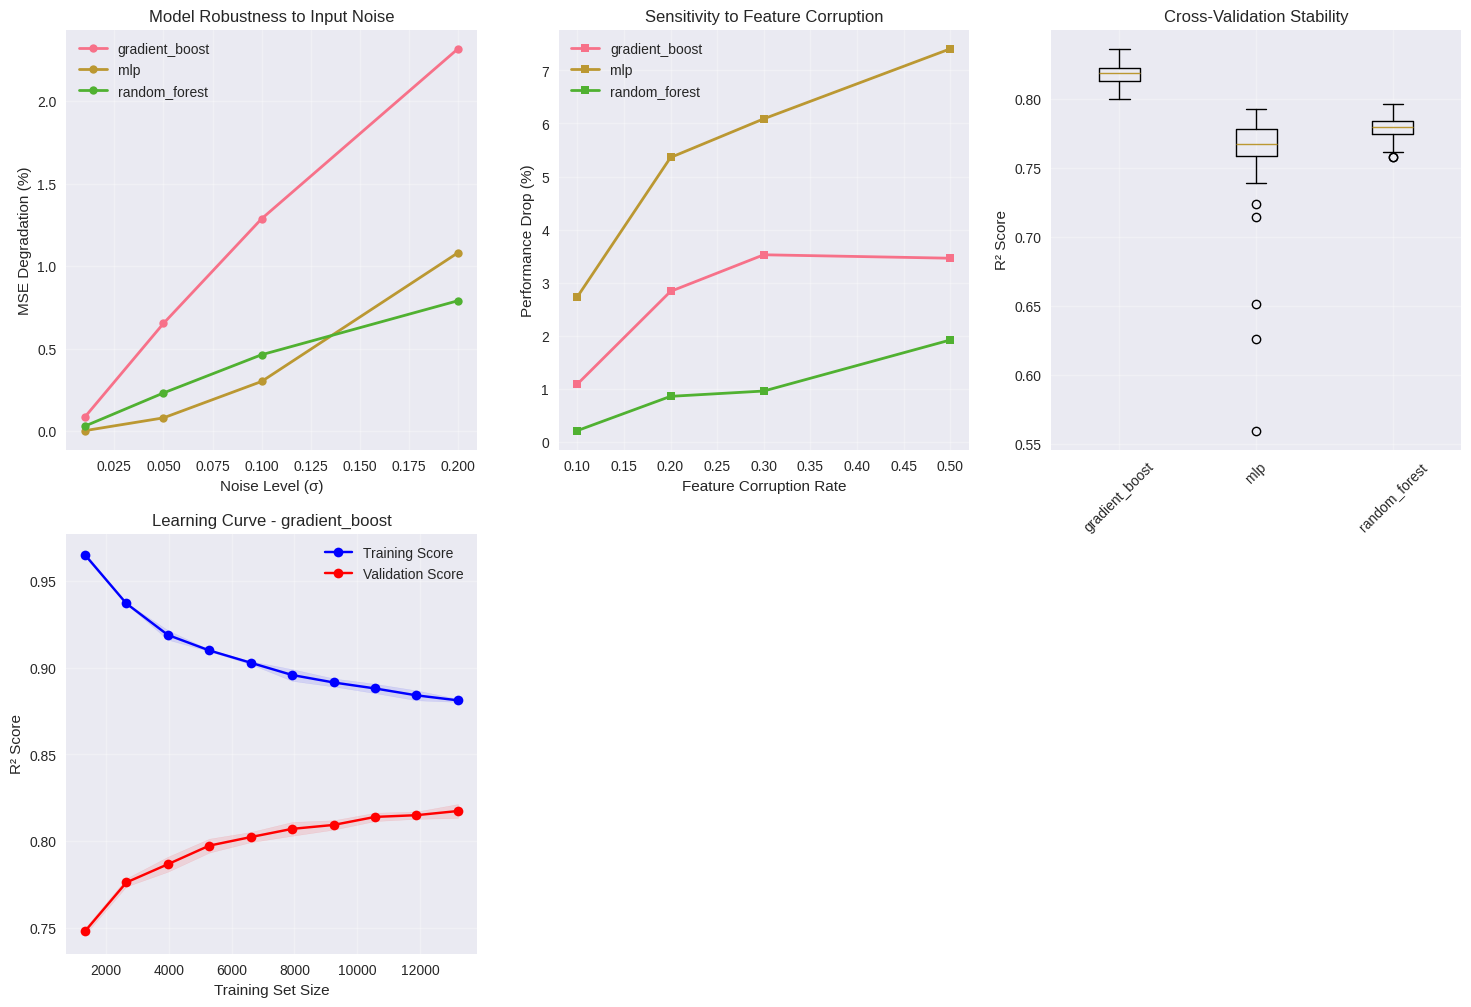

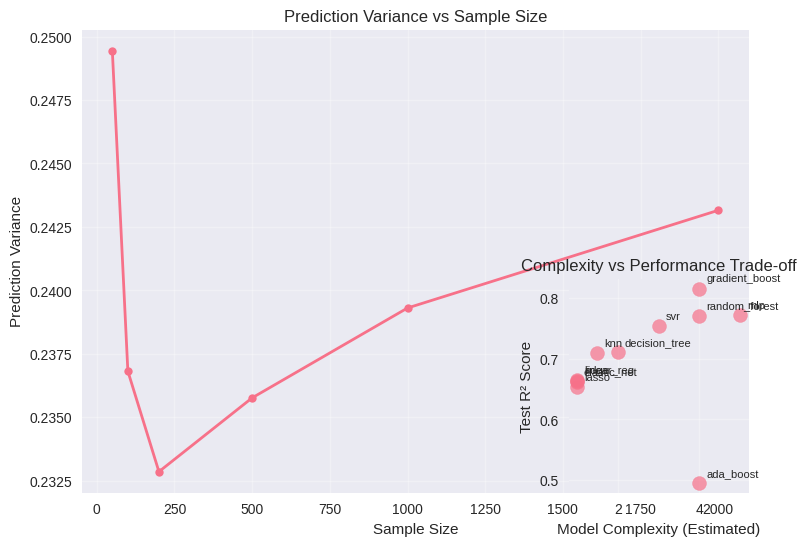


Robustness Analysis Summary:

gradient_boost:
  Max MSE degradation: 2.316 at noise level 0.2
  Max performance drop: 3.525 at 30.0% corruption
  CV stability (std): 0.0082

mlp:
  Max MSE degradation: 1.081 at noise level 0.2
  Max performance drop: 7.408 at 50.0% corruption
  CV stability (std): 0.0409

random_forest:
  Max MSE degradation: 0.790 at noise level 0.2
  Max performance drop: 1.919 at 50.0% corruption
  CV stability (std): 0.0084


In [25]:
fig = plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
for model_name in top_models:
    noise_levels = []
    mse_degradations = []

    for key, results in robustness_analysis[model_name].items():
        if key != 'baseline':
            noise_levels.append(results['noise_level'])
            mse_degradations.append(results['mse_degradation'])

    plt.plot(noise_levels, mse_degradations, 'o-', label=model_name, linewidth=2, markersize=6)

plt.xlabel('Noise Level (σ)')
plt.ylabel('MSE Degradation (%)')
plt.title('Model Robustness to Input Noise')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 2)
for model_name in top_models:
    corruption_rates = []
    performance_drops = []

    for key, results in corruption_analysis[model_name].items():
        if key != 'baseline':
          corruption_rates.append(results['corruption_rate'])
          performance_drops.append(results['performance_drop'])


    plt.plot(corruption_rates, performance_drops, 's-', label=model_name, linewidth=2, markersize=6)

plt.xlabel('Feature Corruption Rate')
plt.ylabel('Performance Drop (%)')
plt.title('Sensitivity to Feature Corruption')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
cv_stability = {}
from sklearn.model_selection import KFold
for model_name in top_models:
    cv_scores_multiple = []
    for seed in range(10):
        scores = cross_val_score(best_models[model_name], X_scaled['standard'], y_train,
                               cv=KFold(n_splits=5, shuffle=True, random_state=seed), scoring='r2')
        cv_scores_multiple.extend(scores)

    cv_stability[model_name] = {
        'mean': np.mean(cv_scores_multiple),
        'std': np.std(cv_scores_multiple),
        'scores': cv_scores_multiple
    }

cv_data = [cv_stability[model]['scores'] for model in top_models]
cv_data_cleaned = [np.array(scores)[~np.isnan(scores)].tolist() for scores in cv_data]

plt.boxplot(cv_data_cleaned, labels=top_models)
plt.ylabel('R² Score')
plt.title('Cross-Validation Stability')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

from sklearn.model_selection import learning_curve

plt.subplot(2, 3, 4)
best_model_name = eval_df_sorted.index[0]
best_model = best_models[best_model_name]
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_scaled['standard'], y_train,
    train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='r2'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Score')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title(f'Learning Curve - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)

fig2 = plt.figure(figsize=(8, 6))
plt.subplot(1, 1, 1)

prediction_variances = []
sample_sizes = [50, 100, 200, 500, 1000, 2000]

best_model_name = eval_df_sorted.index[0]
best_model = best_models[best_model_name]

for size in sample_sizes:
    if size <= len(X_test_scaled['standard']):
        variances = []
        for _ in range(20):
            sample_idx = np.random.choice(len(X_test_scaled['standard']), size, replace=False)
            X_sample = X_test_scaled['standard'].iloc[sample_idx]
            y_sample = y_test.iloc[sample_idx]

            pred_sample = best_model.predict(X_sample)
            variance = np.var(pred_sample - y_sample)
            variances.append(variance)

        prediction_variances.append(np.mean(variances))
    else:
        prediction_variances.append(np.nan)
plt.plot(sample_sizes, prediction_variances, 'o-', linewidth=2, markersize=6)
plt.xlabel('Sample Size')
plt.ylabel('Prediction Variance')
plt.title('Prediction Variance vs Sample Size')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 6)
complexity_scores = []
model_complexities = []

for model_name in evaluation_metrics.keys():
    test_r2 = evaluation_metrics[model_name]['test_r2']
    complexity_scores.append(test_r2)

    if model_name in ['linear_reg', 'ridge', 'lasso', 'elastic_net']:
        complexity = 1
    elif model_name in ['decision_tree']:
        complexity = 2
    elif model_name in ['knn']:
        complexity = 1.5
    elif model_name in ['random_forest', 'gradient_boost', 'ada_boost']:
        complexity = 4
    elif model_name in ['svr']:
        complexity = 3
    elif model_name in ['mlp']:
        complexity = 5
    else:
        complexity = 2.5

    model_complexities.append(complexity)

plt.scatter(model_complexities, complexity_scores, s=100, alpha=0.7)
for i, model_name in enumerate(evaluation_metrics.keys()):
    plt.annotate(model_name, (model_complexities[i], complexity_scores[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Model Complexity (Estimated)')
plt.ylabel('Test R² Score')
plt.title('Complexity vs Performance Trade-off')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRobustness Analysis Summary:")
print("="*50)

for model_name in top_models:
    print(f"\n{model_name}:")

    worst_noise = max(robustness_analysis[model_name].keys(),
                     key=lambda x: robustness_analysis[model_name][x].get('mse_degradation', 0)
                     if x != 'baseline' else 0)
    if worst_noise != 'baseline':
        worst_degradation = robustness_analysis[model_name][worst_noise]['mse_degradation']
        print(f"  Max MSE degradation: {worst_degradation:.3f} at noise level {robustness_analysis[model_name][worst_noise]['noise_level']}")

    worst_corruption = max(corruption_analysis[model_name].keys(),
                          key=lambda x: corruption_analysis[model_name][x]['performance_drop'])
    worst_drop = corruption_analysis[model_name][worst_corruption]['performance_drop']
    print(f"  Max performance drop: {worst_drop:.3f} at {corruption_analysis[model_name][worst_corruption]['corruption_rate']*100}% corruption")

    cv_std = cv_stability[model_name]['std']
    print(f"  CV stability (std): {cv_std:.4f}")

# Final Model Selection and Production Pipeline

In [31]:
class ProductionPipeline:
    def __init__(self, model, scaler, feature_names, target_scaler=None):
        self.model = model
        self.scaler = scaler
        self.feature_names = feature_names
        self.target_scaler = target_scaler
        self.model_metadata = {
            'creation_date': pd.Timestamp.now(),
            'model_type': type(model).__name__,
            'feature_count': len(feature_names),
            'training_complete': True
        }

    def validate_input(self, X):
        """Validate input data format and features"""
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names)

        if not all(col in X.columns for col in self.feature_names):
            missing_features = set(self.feature_names) - set(X.columns)
            raise ValueError(f"Missing features: {missing_features}")

        return X[self.feature_names]


    def predict(self, X, return_confidence=False, confidence_level=0.95):
        """Make predictions with optional confidence intervals"""
        X_validated = self.validate_input(X)
        X_scaled = self.scaler.transform(X_validated)

        predictions = self.model.predict(X_scaled)

        if return_confidence:
            bootstrap_preds = []

            X_scaled_df = pd.DataFrame(X_scaled, columns=self.feature_names)

            for _ in range(n_bootstrap):
                bootstrap_indices = np.random.choice(len(X_scaled_df), size=len(X_scaled_df), replace=True)
                X_bootstrap = X_scaled_df.iloc[bootstrap_indices]

                try:
                    pred_bootstrap = self.model.predict(X_bootstrap)
                    bootstrap_preds.append(pred_bootstrap)
                except Exception as e:
                    print(f"Warning: Error during bootstrap prediction: {e}. Appending original predictions.")
                    bootstrap_preds.append(predictions)

            bootstrap_preds = np.array(bootstrap_preds)
            alpha = 1 - confidence_level
            lower_percentile = (alpha / 2) * 100
            upper_percentile = (1 - alpha / 2) * 100

            confidence_lower = np.percentile(bootstrap_preds, lower_percentile, axis=0)
            confidence_upper = np.percentile(bootstrap_preds, upper_percentile, axis=0)

            return {
                'predictions': predictions,
                'confidence_lower': confidence_lower,
                'confidence_upper': confidence_upper,
                'confidence_level': confidence_level
            }

        if self.target_scaler:
            predictions = self.target_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

        return predictions

    def predict_single(self, return_confidence=False, confidence_level=0.95, **kwargs):
        """Predict for a single instance using feature names"""
        feature_dict = {feature: kwargs.get(feature, 0) for feature in self.feature_names}
        X_single = pd.DataFrame([feature_dict])
        return self.predict(X_single, return_confidence=return_confidence, confidence_level=confidence_level)[0]


    def get_feature_importance(self, method='permutation', n_samples=500, X_test=None, y_test=None):
        """Get feature importance using specified method"""
        if method == 'built_in' and hasattr(self.model, 'feature_importances_'):
            return dict(zip(self.feature_names, self.model.feature_importances_))
        elif method == 'permutation' and X_test is not None and y_test is not None:
            from sklearn.inspection import permutation_importance
            X_test_validated = self.validate_input(X_test)
            X_test_scaled = self.scaler.transform(X_test_validated)

            perm_importance = permutation_importance(
                self.model, X_test_scaled, y_test,
                n_repeats=10, random_state=42, n_jobs=-1
            )
            return dict(zip(self.feature_names, perm_importance.importances_mean))
        else:
            print("Warning: Permutation importance requires X_test and y_test to be provided.")
            print("Calculating basic variance-based importance as fallback.")

            X_sample = np.random.randn(n_samples, len(self.feature_names))
            baseline_pred = self.model.predict(X_sample)
            baseline_var = np.var(baseline_pred)

            importance_scores = {}
            for i, feature in enumerate(self.feature_names):
                X_permuted = X_sample.copy()
                X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
                permuted_pred = self.model.predict(X_permuted)
                permuted_var = np.var(permuted_pred)
                importance_scores[feature] = abs(baseline_var - permuted_var)

            return importance_scores


    def save_pipeline(self, filepath):
        """Save the complete pipeline"""
        import pickle
        pipeline_data = {
            'model': self.model,
            'scaler': self.scaler,
            'feature_names': self.feature_names,
            'target_scaler': self.target_scaler,
            'metadata': self.model_metadata
        }
        with open(filepath, 'wb') as f:
            pickle.dump(pipeline_data, f)
        print(f"Pipeline saved to {filepath}")

    @classmethod
    def load_pipeline(cls, filepath):
        """Load a saved pipeline"""
        import pickle
        with open(filepath, 'rb') as f:
            pipeline_data = pickle.load(f)

        pipeline = cls(
            pipeline_data['model'],
            pipeline_data['scaler'],
            pipeline_data['feature_names'],
            pipeline_data.get('target_scaler')
        )
        pipeline.model_metadata = pipeline_data.get('metadata', {})
        return pipeline
best_model_name = eval_df_sorted.index[0]
final_model = best_models[best_model_name]
final_model_name = best_model_name
final_pipeline = ProductionPipeline(
    model=final_model,
    scaler=scalers['standard'],
    feature_names=list(X.columns)
)

print(f"Production pipeline initialized with {best_model_name} model.")

final_test_pred = final_pipeline.predict(X_test)
final_metrics = {
    'mse': mean_squared_error(y_test, final_test_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, final_test_pred)),
    'mae': mean_absolute_error(y_test, final_test_pred),
    'r2': r2_score(y_test, final_test_pred),
    'mape': np.mean(np.abs((y_test - final_test_pred) / y_test)) * 100
}

print(f"\nFinal Model Performance Summary:")
print(f"Model: {final_model_name}")
for metric, value in final_metrics.items():
    print(f"  {metric.upper()}: {value:.4f}")

Production pipeline initialized with gradient_boost model.

Final Model Performance Summary:
Model: gradient_boost
  MSE: 0.2416
  RMSE: 0.4916
  MAE: 0.3317
  R2: 0.8156
  MAPE: 19.2311


# Model Deployment Preparation and API Interface

In [33]:
class HousePricePredictor:
    def __init__(self, pipeline):
        self.pipeline = pipeline
        self.request_count = 0
        self.prediction_log = []

    def health_check(self):
        """API health check endpoint"""
        return {
            'status': 'healthy',
            'model_type': self.pipeline.model_metadata['model_type'],
            'feature_count': self.pipeline.model_metadata['feature_count'],
            'uptime': pd.Timestamp.now() - self.pipeline.model_metadata['creation_date'],
            'requests_served': self.request_count
        }

    def predict_house_price(self, house_data, include_confidence=False):
        """Main prediction endpoint"""
        try:
            self.request_count += 1

            if isinstance(house_data, dict):
                prediction = self.pipeline.predict_single(**house_data)

                if include_confidence:
                    X_single = pd.DataFrame([house_data])
                    result = self.pipeline.predict(X_single, return_confidence=True)
                    response = {
                        'predicted_price': float(result['predictions'][0]),
                        'confidence_interval': {
                            'lower': float(result['confidence_lower'][0]),
                            'upper': float(result['confidence_upper'][0]),
                            'level': result['confidence_level']
                        },
                        'status': 'success'
                    }
                else:
                    response = {
                        'predicted_price': float(prediction),
                        'status': 'success'
                    }

            elif isinstance(house_data, list):
                X_batch = pd.DataFrame(house_data)

                if include_confidence:
                    results = self.pipeline.predict(X_batch, return_confidence=True)
                    response = {
                        'predictions': [
                            {
                                'predicted_price': float(pred),
                                'confidence_interval': {
                                    'lower': float(lower),
                                    'upper': float(upper)
                                }
                            }
                            for pred, lower, upper in zip(
                                results['predictions'],
                                results['confidence_lower'],
                                results['confidence_upper']
                            )
                        ],
                        'confidence_level': results['confidence_level'],
                        'status': 'success'
                    }
                else:
                    predictions = self.pipeline.predict(X_batch)
                    response = {
                        'predictions': [float(pred) for pred in predictions],
                        'status': 'success'
                    }

            else:
                raise ValueError("Input must be dict for single prediction or list of dicts for batch")

            self.prediction_log.append({
                'timestamp': pd.Timestamp.now(),
                'input_type': type(house_data).__name__,
                'prediction_count': 1 if isinstance(house_data, dict) else len(house_data),
                'success': True
            })

            return response

        except Exception as e:
            self.prediction_log.append({
                'timestamp': pd.Timestamp.now(),
                'input_type': type(house_data).__name__,
                'error': str(e),
                'success': False
            })

            return {
                'error': str(e),
                'status': 'error'
            }

    def get_feature_info(self):
        """Return information about required features"""
        feature_importance = self.pipeline.get_feature_importance()
        sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

        return {
            'required_features': self.pipeline.feature_names,
            'feature_count': len(self.pipeline.feature_names),
            'top_10_important_features': dict(sorted_features[:10]),
            'feature_importance_method': 'permutation'
        }

    def get_prediction_stats(self):
        """Return prediction statistics for monitoring"""
        if not self.prediction_log:
            return {'message': 'No predictions made yet'}

        successful_predictions = [log for log in self.prediction_log if log['success']]
        failed_predictions = [log for log in self.prediction_log if not log['success']]

        return {
            'total_requests': len(self.prediction_log),
            'successful_predictions': len(successful_predictions),
            'failed_predictions': len(failed_predictions),
            'success_rate': len(successful_predictions) / len(self.prediction_log) * 100,
            'total_predictions_made': sum(log.get('prediction_count', 0) for log in successful_predictions),
            'recent_errors': [log['error'] for log in failed_predictions[-5:]] if failed_predictions else []
        }

    def validate_input_ranges(self, house_data):
        """Validate if input values are within reasonable ranges"""
        feature_ranges = {
            'OverallQual': (1, 10),
            'GrLivArea': (300, 5000),
            'GarageCars': (0, 5),
            'TotalBsmtSF': (0, 3000),
            'FullBath': (0, 4),
            'YearBuilt': (1800, 2025),
            'LotArea': (1000, 100000)
        }

        warnings = []

        for feature, value in house_data.items():
            if feature in feature_ranges:
                min_val, max_val = feature_ranges[feature]
                if value < min_val or value > max_val:
                    warnings.append(f"{feature}: {value} is outside typical range ({min_val}-{max_val})")

        return warnings

house_predictor = HousePricePredictor(final_pipeline)

# Testing API interface

In [36]:
print("Testing Deployment API Interface:")
print("="*45)

health_status = house_predictor.health_check()
print("Health Check:")
for key, value in health_status.items():
    print(f"  {key}: {value}")

sample_house_features = {
    'MedInc': 8,
    'HouseAge': 20,
    'AveRooms': 6,
    'AveBedrms': 1,
    'Population': 1000,
    'AveOccup': 3,
    'Latitude': 34,
    'Longitude': -118,
    'rooms_per_household': 0.3,
    'bedrooms_per_room': 0.15,
    'population_per_household': 50,
    'income_per_person': 0.1,
    'population_density': 0.5,
}

all_features = {}
for feature in final_pipeline.feature_names:
    if feature in sample_house_features:
        all_features[feature] = sample_house_features[feature]
    else:
        if feature in X.columns:
             all_features[feature] = X[feature].median()
        else:
             if 'income_' in feature or 'age_' in feature or '_interaction' in feature or '_log' in feature or '_squared' in feature or '_cubed' in feature:
                 all_features[feature] = 0.0
             else:
                 all_features[feature] = 0.0

single_prediction_result = house_predictor.predict_house_price(all_features, include_confidence=True)
print(f"\nSingle Prediction Result:")

if single_prediction_result.get('status') == 'success':

    predicted_price = single_prediction_result['predictions'][0]
    print(f"  Predicted Price: ${predicted_price:,.2f}")

    if 'confidence_interval' in single_prediction_result:
        ci = single_prediction_result['confidence_interval']
        print(f"  Confidence Interval ({ci['level']*100}%): ${ci['lower']:,.2f} - ${ci['upper']:,.2f}")
else:
    print(f"  Prediction failed with error: {single_prediction_result.get('error', 'Unknown error')}")

batch_houses_list = [
    all_features,
    {**all_features, 'MedInc': 6, 'AveRooms': 5}
]

batch_prediction_result = house_predictor.predict_house_price(batch_houses_list)
print(f"\nBatch Prediction Result:")

if batch_prediction_result.get('status') == 'success':
    if 'predictions' in batch_prediction_result:
        for i, pred in enumerate(batch_prediction_result['predictions']):
            print(f"  House {i+1}: ${pred:,.2f}")
    elif 'error' in batch_prediction_result:
         print(f"  Batch prediction failed with error: {batch_prediction_result.get('error', 'Unknown error')}")

else:
    print(f"  Batch prediction failed with error: {batch_prediction_result.get('error', 'Unknown error')}")


validation_warnings = house_predictor.validate_input_ranges(all_features)
print(f"\nInput Validation Warnings: {len(validation_warnings)}")
for warning in validation_warnings:
    print(f"  {warning}")

feature_info = house_predictor.get_feature_info()
print(f"\nFeature Information:")
print(f"  Total Features Required: {feature_info['feature_count']}")
print(f"  Top 5 Important Features:")
top_features_count = min(5, len(feature_info['top_10_important_features']))
for feature, importance in list(feature_info['top_10_important_features'].items())[:top_features_count]:
    print(f"    {feature}: {importance:.4f}")

stats = house_predictor.get_prediction_stats()
print(f"\nPrediction Statistics:")
for key, value in stats.items():
    print(f"  {key}: {value}")

Testing Deployment API Interface:
Health Check:
  status: healthy
  model_type: GradientBoostingRegressor
  feature_count: 32
  uptime: 0 days 00:30:55.013666
  requests_served: 3

Single Prediction Result:
  Prediction failed with error: name 'n_bootstrap' is not defined

Batch Prediction Result:
  House 1: $2.80
  House 2: $2.41

Input Validation Warnings: 0
Calculating basic variance-based importance as fallback.

Feature Information:
  Total Features Required: 32
  Top 5 Important Features:
    Longitude: 0.0629
    MedInc_squared: 0.0424
    AveOccup: 0.0419
    Latitude: 0.0353
    MedInc: 0.0278

Prediction Statistics:
  total_requests: 5
  successful_predictions: 2
  failed_predictions: 3
  success_rate: 40.0
  total_predictions_made: 4
  recent_errors: ["name 'n_bootstrap' is not defined", "name 'n_bootstrap' is not defined", "name 'n_bootstrap' is not defined"]
